In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pingouin as pg
import numpy as np
from scipy.stats import spearmanr
import os
import shutil
from tqdm import tqdm
import random
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression


## Load all collected data from csv file

#### Firstly, load file with summary metrics with repo and source code files

In [3]:
absolute_file_path = '/Users/rmgaliullin/cam_data_600k/data/all.csv'
origin_all_data = pd.read_csv(absolute_file_path)

/var/folders/_7/w61_y6mj5bgdr26d9sk7tmps8zhr5b/T/ipykernel_1627/3946247047.py:2: DtypeWarning: Columns (15,23) have mixed types. Specify dtype option on import or set low_memory=False.
  origin_all_data = pd.read_csv(absolute_file_path)


#### Secondly, get files from each repo separetaly and mearch with comman table

In [4]:
df = origin_all_data[["repo", "java_file"]]
columns = ['cc', 'nobl', 'loc', 'hse', 'hsd', 'hsv', 'coco', 'midx', 'nocl']

merged_df = df.copy()
for i in columns:
    temp = pd.read_csv(f"/Users/rmgaliullin/cam_data_600k/data/{i}.csv")
    temp = temp.drop_duplicates(['repo', 'java_file'])
    merged_df = pd.merge(merged_df, temp, on=['repo', 'java_file'], how='inner')

In [5]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 606000 entries, 0 to 605999
Data columns (total 11 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   repo       606000 non-null  object 
 1   java_file  606000 non-null  object 
 2   cc         606000 non-null  int64  
 3   nobl       606000 non-null  int64  
 4   loc        606000 non-null  int64  
 5   hse        606000 non-null  float64
 6   hsd        606000 non-null  float64
 7   hsv        606000 non-null  float64
 8   coco       606000 non-null  int64  
 9   midx       606000 non-null  float64
 10  nocl       606000 non-null  int64  
dtypes: float64(4), int64(5), object(2)
memory usage: 50.9+ MB


#### Validate that concatenated repo data is equal to data in all-data table (drop test repo "yegor256/jaxec")

In [6]:
joint_values = pd.merge(origin_all_data, merged_df, on=['repo', 'java_file'], suffixes=('_df1', '_df2'), how='right')
joint_values = joint_values[joint_values['repo'] != 'yegor256/jaxec']

assert (joint_values['cc_df1'].astype(int) == joint_values['cc_df2']).all()
assert (joint_values['coco_df1'].astype(int) == joint_values['coco_df2']).all()
assert (joint_values['hsv_df1'].astype(float) == joint_values['hsv_df2']).all()
assert (joint_values['hse_df1'].astype(float) == joint_values['hse_df2']).all()
assert (joint_values['hsd_df1'].astype(float) == joint_values['hsd_df2']).all()
assert (joint_values['loc_df1'].astype(int) == joint_values['loc_df2']).all()
assert (joint_values['nobl_df1'].astype(int) == joint_values['nobl_df2']).all()
assert (joint_values['midx_df1'].astype(float) == joint_values['midx_df2']).all()
assert (joint_values['nocl_df1'].astype(int) == joint_values['nocl_df2']).all()

merged_df = merged_df[merged_df['repo'] != 'yegor256/jaxec']

In [7]:
result_df = merged_df.copy()
result_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 605966 entries, 17 to 605999
Data columns (total 11 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   repo       605966 non-null  object 
 1   java_file  605966 non-null  object 
 2   cc         605966 non-null  int64  
 3   nobl       605966 non-null  int64  
 4   loc        605966 non-null  int64  
 5   hse        605966 non-null  float64
 6   hsd        605966 non-null  float64
 7   hsv        605966 non-null  float64
 8   coco       605966 non-null  int64  
 9   midx       605966 non-null  float64
 10  nocl       605966 non-null  int64  
dtypes: float64(4), int64(5), object(2)
memory usage: 55.5+ MB


## Reorgonize collected data

#### Exclude 2 lines of the signuter and of the last "\}" in order to work only with **body** of the method

In [8]:
result_df['loc'] = (result_df['loc'] - 2).clip(lower=0)

#### Add column with blank line ratio (aka bl_ratio) = nobl / loc, and comment line ratio (aka cl_ratio) = nocl / loc,

In [9]:
result_df.loc[:, "bl_ratio"] = result_df["nobl"] / result_df["loc"]
result_df.loc[:, "cl_ratio"] = result_df["nocl"] / result_df["loc"]

### Split dataset into 3 groups:
- _group A_ (aka subset_df) - all methods
- _group B_ (aka subset_df_3_40) - methods with 1 $\lt$ LoC $\le$ 42
- _group C_ (aka subset_df_3_40_with_non_zero_bl) methods with 1 $\lt$ LoC $\le$ 42 and NoBL $\gt$ 0

In [10]:
# Extract the relevant columns
selected_columns = ['cc', 'nobl', 'loc', 'hse', 'hsd', 'hsv', 'coco', 'midx', 'nocl', 'bl_ratio', 'cl_ratio']
subset_df = result_df[selected_columns]
subset_df_3_40 = subset_df[(subset_df['loc'] <= 42) & (subset_df['loc'] > 1)]
subset_df_3_40_with_non_zero_bl = subset_df_3_40[(subset_df['nobl'] > 1)]

/var/folders/_7/w61_y6mj5bgdr26d9sk7tmps8zhr5b/T/ipykernel_1627/567013462.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  subset_df_3_40_with_non_zero_bl = subset_df_3_40[(subset_df['nobl'] > 1)]


#### Build additional set of the same groups with more coonditions
- nobl_[subset_df, subset_df_3_40, subset_df_3_40_with_non_zero_bl] - same groups A, B, and C without column bl_ratio
- robl_[subset_df, subset_df_3_40, subset_df_3_40_with_non_zero_bl] - same groups A, B, and C without column nobl and **finite**, **not null** bl_ratio values

In [11]:
nobl_subset_df = subset_df.drop(columns=['bl_ratio'], errors='ignore')
nobl_subset_df_3_40 = subset_df_3_40.drop(columns=['bl_ratio'], errors='ignore')
nobl_subset_df_3_40_with_non_zero_bl = subset_df_3_40_with_non_zero_bl.drop(columns=['bl_ratio'], errors='ignore')
nobl_subset_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 605966 entries, 17 to 605999
Data columns (total 10 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   cc        605966 non-null  int64  
 1   nobl      605966 non-null  int64  
 2   loc       605966 non-null  int64  
 3   hse       605966 non-null  float64
 4   hsd       605966 non-null  float64
 5   hsv       605966 non-null  float64
 6   coco      605966 non-null  int64  
 7   midx      605966 non-null  float64
 8   nocl      605966 non-null  int64  
 9   cl_ratio  585613 non-null  float64
dtypes: float64(5), int64(5)
memory usage: 67.0 MB


In [12]:
robl_subset_df = subset_df[np.isfinite(result_df['bl_ratio']) & ~result_df['bl_ratio'].isna()].drop(columns=['nobl'], errors='ignore')
robl_subset_df_3_40 = subset_df_3_40[np.isfinite(result_df['bl_ratio']) & ~result_df['bl_ratio'].isna()].drop(columns=['nobl'], errors='ignore')
robl_subset_df_3_40_with_non_zero_bl = subset_df_3_40_with_non_zero_bl[np.isfinite(result_df['bl_ratio']) & ~result_df['bl_ratio'].isna()].drop(columns=['nobl'], errors='ignore')
robl_subset_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 581948 entries, 18 to 605999
Data columns (total 10 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   cc        581948 non-null  int64  
 1   loc       581948 non-null  int64  
 2   hse       581948 non-null  float64
 3   hsd       581948 non-null  float64
 4   hsv       581948 non-null  float64
 5   coco      581948 non-null  int64  
 6   midx      581948 non-null  float64
 7   nocl      581948 non-null  int64  
 8   bl_ratio  581948 non-null  float64
 9   cl_ratio  581948 non-null  float64
dtypes: float64(6), int64(4)
memory usage: 48.8 MB


/var/folders/_7/w61_y6mj5bgdr26d9sk7tmps8zhr5b/T/ipykernel_1627/3571949685.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  robl_subset_df_3_40 = subset_df_3_40[np.isfinite(result_df['bl_ratio']) & ~result_df['bl_ratio'].isna()].drop(columns=['nobl'], errors='ignore')
/var/folders/_7/w61_y6mj5bgdr26d9sk7tmps8zhr5b/T/ipykernel_1627/3571949685.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  robl_subset_df_3_40_with_non_zero_bl = subset_df_3_40_with_non_zero_bl[np.isfinite(result_df['bl_ratio']) & ~result_df['bl_ratio'].isna()].drop(columns=['nobl'], errors='ignore')


## Extracting information from data

#### Build distribution plots for several complexition metrics between each group

In [13]:
def build_box_plot(metric, group_A, group_B, group_C, axis, bottom, top):
    data_A = group_A[[metric]].assign(Type="any method")
    data_B = group_B[[metric]].assign(Type="any NOBL")
    data_C = group_C[[metric]].assign(Type="NOBL = 0")

    # Concatenate the two subsets
    result_df = pd.concat([data_A, data_B, data_C], ignore_index=True)

    # Add another box plot for 'hsd' column where 'nobl' == 0 on the same axis
    sns.boxplot(data=result_df, y=metric, hue="Type")

    # Set labels and title
    axis.set_ylim(bottom=bottom, top=top) 
    axis.set_ylabel(metric.upper(), fontdict={'size':30, 'font':'times new roman'})
    axis.tick_params(labelsize=23)
    
    axis.set_xticks([]) 
    axis.get_legend().remove()

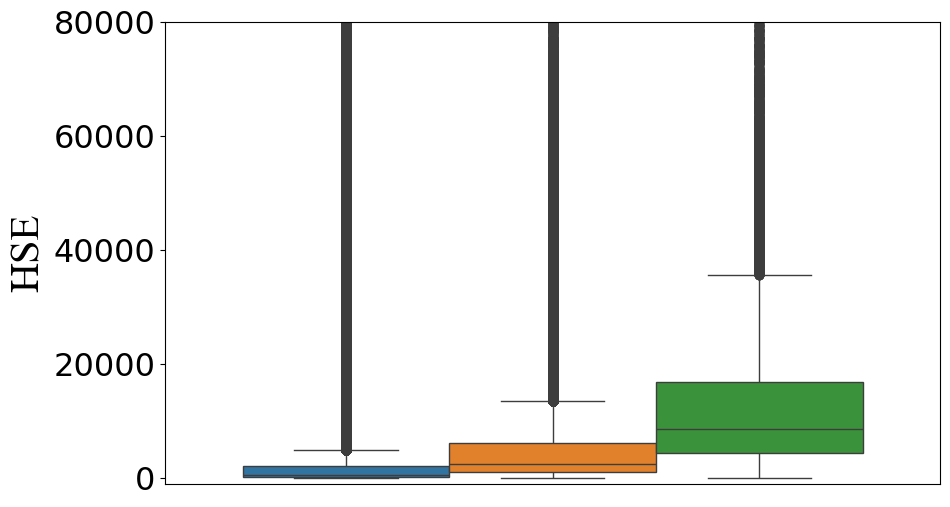

In [14]:
_, ax = plt.subplots(figsize=(10, 6))
build_box_plot('hse', subset_df, subset_df_3_40, subset_df_3_40_with_non_zero_bl, ax, bottom=-1000, top=80000)
plt.show()

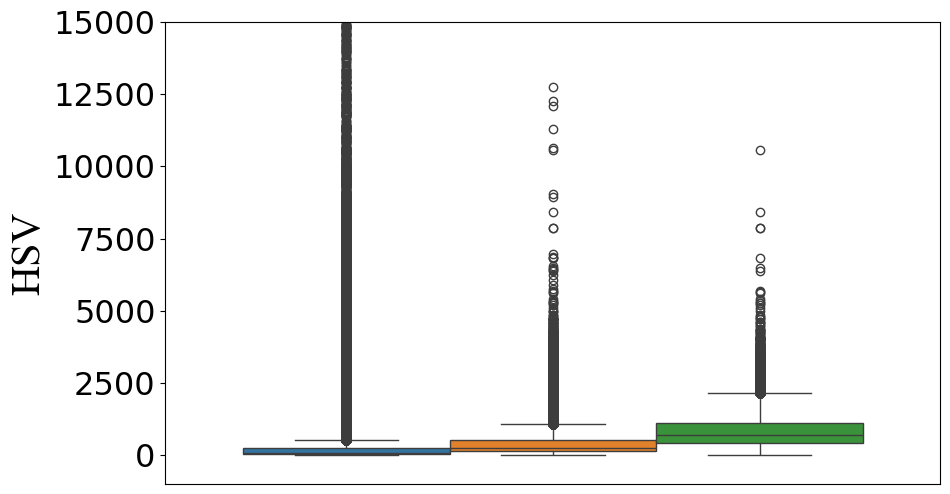

In [15]:
_, ax = plt.subplots(figsize=(10, 6))
build_box_plot('hsv', subset_df, subset_df_3_40, subset_df_3_40_with_non_zero_bl, ax, bottom=-1000, top=15000)
plt.show()

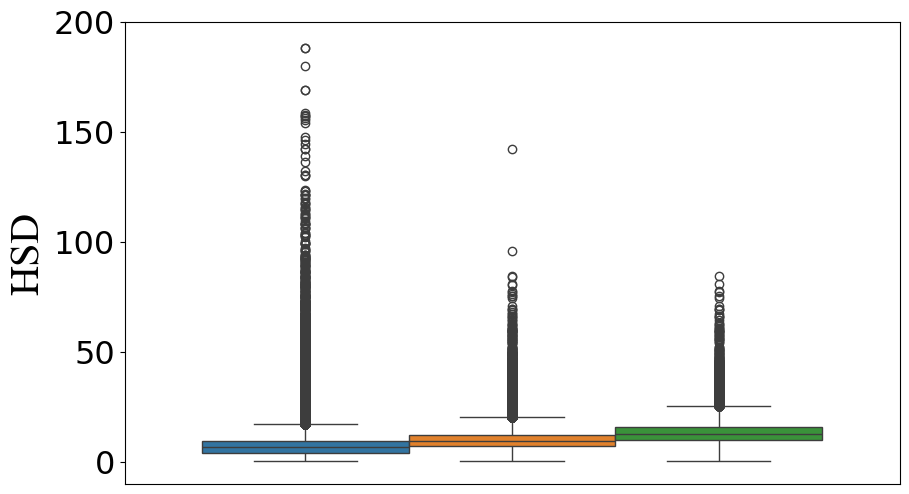

In [16]:
_, ax = plt.subplots(figsize=(10, 6))
build_box_plot('hsd', subset_df, subset_df_3_40, subset_df_3_40_with_non_zero_bl, ax, bottom=-10, top=200)
plt.show()

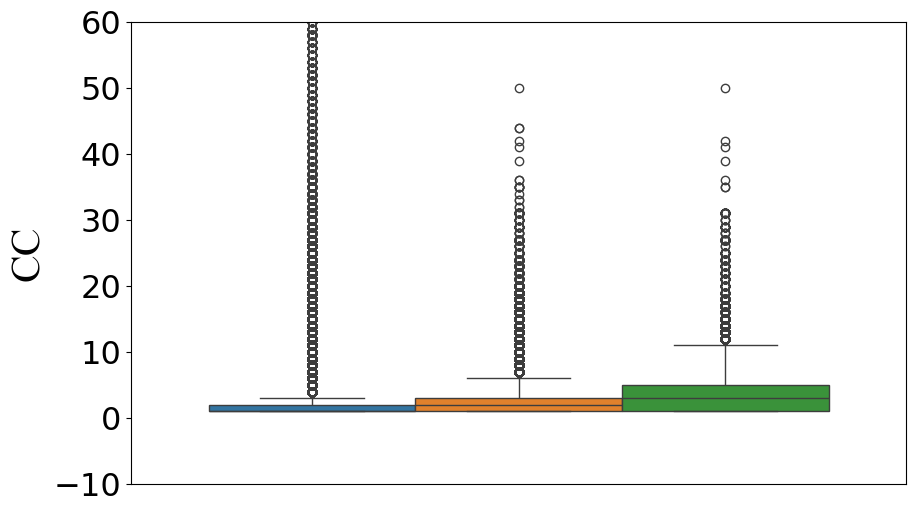

In [17]:
_, ax = plt.subplots(figsize=(10, 6))
build_box_plot('cc', subset_df, subset_df_3_40, subset_df_3_40_with_non_zero_bl, ax, bottom=-10, top=60)
plt.show()

## Building .dat files for paper plots

In [57]:
def cluster_and_summarize(df, col1, col2, n_clusters):
    scaler = MinMaxScaler()
    df[[f'{col1}_norm', f'{col2}_norm']] = scaler.fit_transform(df[[col1, col2]])

    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    df['cluster'] = kmeans.fit_predict(df[[f'{col1}_norm', f'{col2}_norm']])

    cluster_info = df.groupby('cluster').agg(
        count=('cluster', 'size'),
        **{f'{col1}': (col1, 'mean'), f'{col2}': (col2, 'mean')}
    ).reset_index()
    
    cluster_info = cluster_info.drop(columns=['cluster'])

    return cluster_info

### Generate data in csv-files

In [58]:
force_rewrite_data = True

metrix_mapping = {'bl_ratio':'robl', 'cl_ratio':'rocl', 'nocl':'ncl', 'hse':'hse', 'hsd':'hsd', 'hsv':'hsv'}
data = {'groupA': nobl_subset_df}
distance_by_metric = {'cc': 0, 'loc':0.01, 'hse':30, 'hsd':0.1, 'hsv': 4.3, 'coco': 0, 'midx': 0.09}
step_by_metric = {'cc': 1.1, 'loc':1.1, 'hse':1.1, 'hsd': 1.2, 'hsv': 1.01, 'coco': 1.1, 'midx': 1.1}

In [59]:

for i in tqdm(['loc', 'hse', 'hsd', 'hsv', 'coco', 'midx']):
    for group, subset in data.items():
        if i == 'nobl':
            continue
        file_name = f'/Users/rmgaliullin/cam_data_600k/small/{group}_nobl_{metrix_mapping.get(i, i)}.csv'
        best_values = cluster_and_summarize(subset, col1="nobl", col2=i, n_clusters=2000)
        best_values = best_values.sort_values(by='count', ascending=False).reset_index(drop=True)
        result_df_from_file = pd.read_csv(file_name, sep=' ')
        more = best_values.shape[0] > result_df_from_file.shape[0]
            
        if force_rewrite_data or more:
            result_df = best_values.rename(columns=metrix_mapping)
            result_df[metrix_mapping.get(i, i)] = result_df[metrix_mapping.get(i, i)].astype(int)
            result_df.to_csv(file_name, index=False, sep=' ')

        print(f"Done NOBL {i} number of points is {len(best_values)} in group {group}. It is more {more} than was")

 17%|█▋        | 1/6 [00:55<04:39, 55.92s/it]

Done NOBL loc number of points is 2000 in group groupA. It is more False than was


 33%|███▎      | 2/6 [01:44<03:27, 51.81s/it]

Done NOBL hse number of points is 2000 in group groupA. It is more False than was


 50%|█████     | 3/6 [02:41<02:42, 54.02s/it]

Done NOBL hsd number of points is 2000 in group groupA. It is more False than was


 67%|██████▋   | 4/6 [03:30<01:43, 51.98s/it]

Done NOBL hsv number of points is 2000 in group groupA. It is more False than was


 83%|████████▎ | 5/6 [04:16<00:49, 49.91s/it]

Done NOBL coco number of points is 2000 in group groupA. It is more False than was


100%|██████████| 6/6 [05:13<00:00, 52.21s/it]

Done NOBL midx number of points is 2000 in group groupA. It is more False than was


In [52]:
for i in tqdm(['cc', 'nocl']):
    for group, subset in data.items():
        file_name = f'/Users/rmgaliullin/cam_data_600k/small/{group}_nobl_{metrix_mapping.get(i, i)}.csv'
        best_values = subset[['nobl', i]].value_counts().reset_index(name='count')
        best_values = best_values.sort_values(by='count', ascending=False).reset_index(drop=True)
        result_df_from_file = pd.read_csv(file_name, sep=' ')
        more = len(best_values) > result_df_from_file.shape[0]
        if force_rewrite_data or more:
            result_df = best_values.rename(columns=metrix_mapping)
            result_df[metrix_mapping.get(i, i)] = result_df[metrix_mapping.get(i, i)].astype(int)
            result_df.to_csv(file_name, index=False, sep=' ')

        print(f"Done NOBL {i} using value counts {len(best_values)} in group {group}. It is more {more} than was")

100%|██████████| 2/2 [00:00<00:00, 36.58it/s]

Done NOBL cc using value counts 1577 in group groupA. It is more False than was
Done NOBL nocl using value counts 1253 in group groupA. It is more False than was


In [42]:
force_rewrite_data = True

metrix_mapping = {'bl_ratio':'robl', 'cl_ratio':'rocl', 'nocl':'ncl', 'hse':'hse', 'hsd':'hsd', 'hsv':'hsv'}
data = {'groupA': robl_subset_df} #,'groupB': robl_subset_df_3_40,'groupC': robl_subset_df_3_40_with_non_zero_bl}
distance_by_metric = {'cc': 0.00208, 'loc':0.01, 'hse':39.93, 'hsd':0.067, 'hsv': 1.43, 'coco': 0.0039, 'midx': 0.039, 'nocl':0.00159}
step_by_metric = {'cc': 1.01, 'loc':1.1, 'hse':1.1, 'hsd': 1.1, 'hsv': 1.01, 'coco': 1.1, 'midx': 1.1, 'nocl':1.1}

In [47]:
for i in tqdm(['cc', 'loc', 'hse', 'hsd', 'hsv', 'coco', 'midx', 'nocl', 'cl_ratio']):
    for group, subset in data.items():
        if i == 'bl_ratio':
            continue
        
        file_name = f'/Users/rmgaliullin/cam_data_600k/small/{group}_robl_{metrix_mapping.get(i, i)}.csv'
        best_values = cluster_and_summarize(subset, col1="bl_ratio", col2=i, n_clusters=2000)
        best_values = best_values.sort_values(by='count', ascending=False).reset_index(drop=True)
        result_df_from_file = pd.read_csv(file_name, sep=' ')
        more = best_values.shape[0] > result_df_from_file.shape[0]
            
        if force_rewrite_data or more:
            result_df = best_values.rename(columns=metrix_mapping)
            result_df[metrix_mapping.get(i, i)] = result_df[metrix_mapping.get(i, i)].astype(int)
            result_df.to_csv(file_name, index=False, sep=' ')
            
        print(f"Done ROBL {i} number of points is {len(best_values)} in group {group}. It is more {more} than was")

 11%|█         | 1/9 [00:51<06:49, 51.14s/it]

Done ROBL cc number of points is 2000 in group groupA. It is more False than was


 22%|██▏       | 2/9 [01:39<05:47, 49.71s/it]

Done ROBL loc number of points is 2000 in group groupA. It is more False than was


 33%|███▎      | 3/9 [02:30<05:02, 50.37s/it]

Done ROBL hse number of points is 2000 in group groupA. It is more False than was


 44%|████▍     | 4/9 [03:22<04:13, 50.71s/it]

Done ROBL hsd number of points is 2000 in group groupA. It is more False than was


 56%|█████▌    | 5/9 [04:12<03:22, 50.67s/it]

Done ROBL hsv number of points is 2000 in group groupA. It is more False than was


 67%|██████▋   | 6/9 [05:02<02:31, 50.43s/it]

Done ROBL coco number of points is 2000 in group groupA. It is more False than was


 78%|███████▊  | 7/9 [05:53<01:41, 50.63s/it]

Done ROBL midx number of points is 2000 in group groupA. It is more False than was


 89%|████████▉ | 8/9 [06:42<00:50, 50.08s/it]

Done ROBL nocl number of points is 2000 in group groupA. It is more False than was


100%|██████████| 9/9 [07:31<00:00, 50.20s/it]

Done ROBL cl_ratio number of points is 2000 in group groupA. It is more True than was


In [46]:
for i in tqdm(['cc', 'loc', 'hse', 'hsd', 'hsv', 'coco', 'midx', 'nocl', 'cl_ratio']):
    for group, subset in data.items():
        file_name = f'/Users/rmgaliullin/cam_data_600k/small/{group}_robl_{metrix_mapping.get(i, i)}.csv'
        best_values = subset[['bl_ratio', i]].value_counts().reset_index(name='count')
        if len(best_values) > 3000:
            continue
        best_values = best_values.sort_values(by='count', ascending=False).reset_index(drop=True)
        result_df_from_file = pd.read_csv(file_name, sep=' ')
        more = len(best_values) > result_df_from_file.shape[0]
        if force_rewrite_data or more:
            result_df = best_values.rename(columns=metrix_mapping)
            result_df[metrix_mapping.get(i, i)] = result_df[metrix_mapping.get(i, i)].astype(int)
            result_df.to_csv(file_name, index=False, sep=' ')

        print(f"Done ROBL {i} using value counts {len(best_values)} in group {group}. It is more {more} than was")

100%|██████████| 9/9 [00:00<00:00, 32.95it/s]


### Build linear regression marks for each metric scatter plot

In [65]:
# Define the parameters
first_options = ['nobl', 'robl']
second_options = ['cc', 'loc', 'hse', 'hsd', 'hsv', 'coco', 'midx', 'ncl']

# Iterate over each combination of first and second
for first in first_options:
    for second in second_options:
        # Construct the file path
        input_file_path = f'/Users/rmgaliullin/cam_data_600k/small/groupA_{first}_{second}.csv'
        output_file_path = f'/Users/rmgaliullin/cam_data_600k/small/groupA_{first}_{second}_linereg.csv'

        # Check if the input file exists
        if not os.path.exists(input_file_path):
            print(f"File not found: {input_file_path}")
            continue
        
        # Read the data from the CSV file
        df = pd.read_csv(input_file_path, delimiter=" ")
        # Ensure the necessary columns exist
        if first not in df.columns or second not in df.columns:
            print(f"Columns {first} or {second} not found in {input_file_path}")
            continue

        # Prepare the data for linear regression
        x = df[[first]].values.reshape(-1, 1)  # Independent variable
        y = df[second].values  # Dependent variable

        # Normalize the independent variable (x)
        scaler = MinMaxScaler()
        x_normalized = scaler.fit_transform(x)

        # Perform linear regression
        model = LinearRegression(deg)
        model.fit(x_normalized, y)

        # Generate points for the regression line
        x_range_normalized = np.linspace(0, 1, 50).reshape(-1, 1)  # Normalized range for x
        y_pred = model.predict(x_range_normalized)

        # Inverse transform the normalized x_range to original scale for output
        x_range_original = scaler.inverse_transform(x_range_normalized)

        # Create a DataFrame for the results
        results_df = pd.DataFrame({
            first: x_range_original.flatten(),
            second: y_pred
        })

        # Save the results to a new CSV file with space as the separator
        results_df.to_csv(output_file_path, index=False, sep=" ")
        print(f"Saved linear regression results to: {output_file_path}")

Saved linear regression results to: /Users/rmgaliullin/cam_data_600k/small/groupA_nobl_cc_linereg.csv
Saved linear regression results to: /Users/rmgaliullin/cam_data_600k/small/groupA_nobl_loc_linereg.csv
Saved linear regression results to: /Users/rmgaliullin/cam_data_600k/small/groupA_nobl_hse_linereg.csv
Saved linear regression results to: /Users/rmgaliullin/cam_data_600k/small/groupA_nobl_hsd_linereg.csv
Saved linear regression results to: /Users/rmgaliullin/cam_data_600k/small/groupA_nobl_hsv_linereg.csv
Saved linear regression results to: /Users/rmgaliullin/cam_data_600k/small/groupA_nobl_coco_linereg.csv
Saved linear regression results to: /Users/rmgaliullin/cam_data_600k/small/groupA_nobl_midx_linereg.csv
Saved linear regression results to: /Users/rmgaliullin/cam_data_600k/small/groupA_nobl_ncl_linereg.csv
Saved linear regression results to: /Users/rmgaliullin/cam_data_600k/small/groupA_robl_cc_linereg.csv
Saved linear regression results to: /Users/rmgaliullin/cam_data_600k/smal

### Make dat-files from their csv examples

In [64]:
def copy_csv_to_dat(directory, depth=1):
    for root, dirs, files in os.walk(directory):
        current_depth = root[len(directory) + 1:].count(os.sep)
        print("inside")
        if current_depth > depth:
            continue
        for file in files:
            if file.endswith('.csv'):
                csv_file_path = os.path.join(root, file)
                dat_file_path = os.path.join(root, 'dat', file.replace('.csv', '.dat'))
                os.makedirs(os.path.dirname(dat_file_path), exist_ok=True)
                print(f"Copying CSV file '{csv_file_path}' to DAT file '{dat_file_path}'")
                with open(csv_file_path, 'r') as csv_file:
                    csv_content = csv_file.read()
                    with open(dat_file_path, 'w') as dat_file:
                        dat_file.write(csv_content)
                    
    
# Specify the directory path
directory_path = '/Users/rmgaliullin/cam_data_600k/small'

# Call the function to copy CSV files to DAT files at depth=1
copy_csv_to_dat(directory_path, depth=1)


inside
Copying CSV file '/Users/rmgaliullin/cam_data_600k/small/groupB_robl_midx.csv' to DAT file '/Users/rmgaliullin/cam_data_600k/small/dat/groupB_robl_midx.dat'
Copying CSV file '/Users/rmgaliullin/cam_data_600k/small/groupA_nobl_bl_ratio.csv' to DAT file '/Users/rmgaliullin/cam_data_600k/small/dat/groupA_nobl_bl_ratio.dat'
Copying CSV file '/Users/rmgaliullin/cam_data_600k/small/groupC_loc_midx.csv' to DAT file '/Users/rmgaliullin/cam_data_600k/small/dat/groupC_loc_midx.dat'
Copying CSV file '/Users/rmgaliullin/cam_data_600k/small/groupA_nobl_hse_linereg.csv' to DAT file '/Users/rmgaliullin/cam_data_600k/small/dat/groupA_nobl_hse_linereg.dat'
Copying CSV file '/Users/rmgaliullin/cam_data_600k/small/groupB_nobl_coco.csv' to DAT file '/Users/rmgaliullin/cam_data_600k/small/dat/groupB_nobl_coco.dat'
Copying CSV file '/Users/rmgaliullin/cam_data_600k/small/groupC_nobl_rocl.csv' to DAT file '/Users/rmgaliullin/cam_data_600k/small/dat/groupC_nobl_rocl.dat'
Copying CSV file '/Users/rmgali

## Prepare statistics

### Calculate pearson and spearman correlation coeff

In [56]:
def calculate_correlations(dataframes, metrics, method='pearson', return_full=False):
    """
    Calculate either Pearson or Spearman correlations for 'nobl' and 'bl_ratio' metrics across groups.

    Parameters:
    - dataframes: dict, nested dictionary of dataframes for each (group, prefix) pair
    - metrics: list, list of metrics to calculate correlations for
    - method: str, either 'pearson' or 'spearman'
    - return_full: bool, if True, returns the full correlation results instead of just the r value

    Returns:
    - DataFrame with multi-level columns for each group and feature, with correlation coefficients or full results
    """
    if method != 'pearson' and method != 'spearman':
        raise ValueError("Method must be 'pearson' or 'spearman'")
    results = {}

    # Loop through each prefix and its associated dataframes
    for prefix, dfs in dataframes.items():
        for group_name, df in dfs.items():
            group_results = []
            
            for metric in metrics:
                # Ensure the metric and prefix are treated as Series
                x = df[metric].values  # Convert to 1D numpy array for the metric
                y = df[prefix].values  # Convert to 1D numpy array for the prefix
                
                correlation = pg.corr(x=x, y=y, method=method)
                
                if return_full:
                    # Append full correlation result
                    group_results.append(correlation[['r', 'CI95%']])
                else:
                    # Extract only the correlation value (r)
                    r_value = correlation['r'].values[0]
                    group_results.append(r_value)
            
            # Store results with a multi-indexed Series for the group and prefix
            results[(group_name, prefix)] = pd.Series(group_results, index=metrics)

    # Convert results dictionary to a DataFrame with multi-level columns
    result_df = pd.DataFrame(results)
    
    # Set multi-level columns with first level as group and second level as 'nobl' or 'bl_ratio'
    result_df.columns.names = ['group', 'feature']
    
    return result_df


Pearson Correlation (r values only):
group      groupA    groupB    groupC    groupA    groupB    groupC
feature      nobl      nobl      nobl  bl_ratio  bl_ratio  bl_ratio
cc       0.356849  0.283058  0.205116  0.104245  0.056389 -0.334712
coco     0.301803  0.301604  0.190454  0.073003  0.058191 -0.348887
hse      0.325400  0.455861  0.366510  0.025450  0.156861 -0.267856
hsv      0.584066  0.543944  0.454342  0.118576  0.213930 -0.367099
hsd      0.523015  0.352822  0.262741  0.222138  0.129705 -0.300385
midx    -0.583841 -0.260665 -0.288931 -0.088927 -0.059114  0.123527

Spearman Correlation (r values only):
group      groupA    groupB    groupC    groupA    groupB    groupC
feature      nobl      nobl      nobl  bl_ratio  bl_ratio  bl_ratio
cc       0.447345  0.266146  0.235179  0.425537  0.197853 -0.426238
coco     0.443867  0.261469  0.218727  0.421987  0.192137 -0.454645
hse      0.504927  0.492064  0.455218  0.505636  0.413002 -0.491275
hsv      0.513503  0.516475  0.471252  0

In [ ]:
dataframes = {
    'nobl': {
        'groupA': nobl_subset_df,
        'groupB': nobl_subset_df_3_40,
        'groupC': nobl_subset_df_3_40_with_non_zero_bl
    },
    'bl_ratio': {
        'groupA': robl_subset_df,
        'groupB': robl_subset_df_3_40,
        'groupC': robl_subset_df_3_40_with_non_zero_bl
    }
}
metrics = ['loc', 'cc', 'coco', 'hse', 'hsv', 'hsd', 'midx', 'nocl']

# Calculate Pearson correlation
pearson_corr_result = calculate_correlations(dataframes, metrics, method='pearson')
print("Pearson Correlation:")
print(pearson_corr_result)

# Calculate Spearman correlation
spearman_corr_result = calculate_correlations(dataframes, metrics, method='spearman')
print("\nSpearman Correlation:")
print(spearman_corr_result)

### Generate latex result tables

In [47]:
def format_correlation_table(df, underline_threshold=0.4):
    # Define the desired column order for groups and features
    ordered_columns = [
        ('groupA', 'nobl'), ('groupA', 'bl_ratio'),
        ('groupB', 'nobl'), ('groupB', 'bl_ratio'),
        ('groupC', 'nobl'), ('groupC', 'bl_ratio')
    ]
    
    # Reorder DataFrame columns to match the desired order
    df = df[ordered_columns]

    # Mapping for metric names to LaTeX \mt{} format with case sensitivity
    metric_mapping = {
        'cc': 'CC',
        'coco': 'CoCo',
        'hse': 'HSE',
        'hsv': 'HSV',
        'hsd': 'HSD',
        'midx': 'MIDX',
        'nocl': 'NCL',
        'loc': 'LoC'
    }
    
    # Start building the LaTeX table string
    table_string = ""
    
    # Loop over each metric (index) in the DataFrame
    for metric in df.index:
        # Use the mapped name for LaTeX formatting, if available
        metric_latex = metric_mapping.get(metric.lower(), metric)
        row = f"\\mt{{{metric_latex}}} "
        
        # Loop over each (group, feature) pair in the ordered columns
        for (group, feature) in ordered_columns:
            # Get the correlation value for the current metric, group, and feature
            value = df.loc[metric, (group, feature)]
            
            # Check if value exceeds underline threshold and format accordingly
            if abs(value) > underline_threshold:
                row += f"& \\ul{{{value:.2f}}} "
            else:
                row += f"& {value:.2f} "
        
        # End the row with a newline character and add it to the table string
        table_string += row + "\\\\\n"

    return table_string


\mt{LoC} & \ul{0.73} & 0.17 & \ul{0.56} & 0.19 & \ul{0.50} & \ul{-0.50} \\
\mt{CC} & 0.36 & 0.10 & 0.28 & 0.06 & 0.21 & -0.33 \\
\mt{CoCo} & 0.30 & 0.07 & 0.30 & 0.06 & 0.19 & -0.35 \\
\mt{HSE} & 0.33 & 0.03 & \ul{0.46} & 0.16 & 0.37 & -0.27 \\
\mt{HSV} & \ul{0.58} & 0.12 & \ul{0.54} & 0.21 & \ul{0.45} & -0.37 \\
\mt{HSD} & \ul{0.52} & 0.22 & 0.35 & 0.13 & 0.26 & -0.30 \\
\mt{MIDX} & \ul{-0.58} & -0.09 & -0.26 & -0.06 & -0.29 & 0.12 \\
\mt{NCL} & \ul{0.57} & 0.21 & \ul{0.42} & 0.25 & \ul{0.41} & 0.13 \\



In [49]:
# Generate the formatted table string
table_string = format_correlation_table(pearson_corr_result)
print(table_string)

\mt{LoC} & \ul{0.73} & 0.17 & \ul{0.56} & 0.19 & \ul{0.50} & \ul{-0.50} \\
\mt{CC} & 0.36 & 0.10 & 0.28 & 0.06 & 0.21 & -0.33 \\
\mt{CoCo} & 0.30 & 0.07 & 0.30 & 0.06 & 0.19 & -0.35 \\
\mt{HSE} & 0.33 & 0.03 & \ul{0.46} & 0.16 & 0.37 & -0.27 \\
\mt{HSV} & \ul{0.58} & 0.12 & \ul{0.54} & 0.21 & \ul{0.45} & -0.37 \\
\mt{HSD} & \ul{0.52} & 0.22 & 0.35 & 0.13 & 0.26 & -0.30 \\
\mt{MIDX} & \ul{-0.58} & -0.09 & -0.26 & -0.06 & -0.29 & 0.12 \\
\mt{NCL} & \ul{0.57} & 0.21 & \ul{0.42} & 0.25 & \ul{0.41} & 0.13 \\



In [50]:
# Generate the formatted table string
table_string = format_correlation_table(spearman_corr_result)
print(table_string)

\mt{LoC} & \ul{0.55} & \ul{0.56} & \ul{0.51} & \ul{0.42} & \ul{0.51} & \ul{-0.62} \\
\mt{CC} & \ul{0.45} & \ul{0.43} & 0.27 & 0.20 & 0.24 & \ul{-0.43} \\
\mt{CoCo} & \ul{0.44} & \ul{0.42} & 0.26 & 0.19 & 0.22 & \ul{-0.45} \\
\mt{HSE} & \ul{0.50} & \ul{0.51} & \ul{0.49} & \ul{0.41} & \ul{0.46} & \ul{-0.49} \\
\mt{HSV} & \ul{0.51} & \ul{0.51} & \ul{0.52} & \ul{0.44} & \ul{0.47} & \ul{-0.49} \\
\mt{HSD} & \ul{0.42} & \ul{0.42} & 0.34 & 0.27 & 0.31 & -0.38 \\
\mt{MIDX} & -0.39 & -0.33 & -0.27 & -0.19 & -0.35 & 0.28 \\
\mt{NCL} & \ul{0.40} & \ul{0.40} & 0.34 & 0.29 & 0.32 & -0.02 \\

